In [1]:
import pandas as pd
import numpy as np
import json
import os
from tqdm.notebook import tqdm
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter, defaultdict
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap

In [2]:
def get_outlier(data):
    Q1 = np.percentile(data, 25, method = 'midpoint') 
    Q2 = np.percentile(data, 50, method = 'midpoint') 
    Q3 = np.percentile(data, 75, method = 'midpoint')
    
    IQR = Q3 - Q1
    
    low_lim = max(Q1 - 1.5 * IQR,min(data))
    up_lim = min(Q3 + 1.5 * IQR, max(data))
    
    return Q2, IQR, low_lim, up_lim

### Summary Table

In [3]:
summary_table = []

In [4]:
user_index = json.load(open("../data/user_index.json",'r'))
commitment_index = json.load(open("../data/commitment_index.json",'r'))

counters = json.load(open("../data/counter.json",'r'))
with open("../data/users_not_found.txt",'r') as fp:
    user_not_found = fp.readlines()
    
with open("../data/private_users.txt",'r') as fp:
    private_users = fp.readlines()
    
user_not_found = [int(i.strip()) for i in user_not_found]
private_users = [int(i.strip()) for i in private_users]

In [5]:
max_user_id = max([int(i) for i in user_index.keys()])

In [6]:
for k,v in tqdm(user_index.items()):
    user_index[k]['date'] = datetime.strptime(v['date'], '%d %b %Y')

  0%|          | 0/655750 [00:00<?, ?it/s]

In [7]:
id_for_1_jan_2023 = 722621
for k,v in tqdm(user_index.items()):
    if int(k)<id_for_1_jan_2023 and v['date'].year == 2023:
        user_index[k]['date'] = None

  0%|          | 0/655750 [00:00<?, ?it/s]

In [8]:
key_date = user_index[str(max_user_id)]['date']
for i in tqdm(range(max_user_id,id_for_1_jan_2023,-1)):
    if str(i) in user_index.keys():
        if user_index[str(i)]['date']> key_date:
            user_index[str(i)]['date'] = None
        else:
            key_date = user_index[str(i)]['date']

  0%|          | 0/20302 [00:00<?, ?it/s]

In [9]:
last_date = user_index['1']['date']
for i in range(1, max_user_id+1):
    if str(i) in user_index.keys():
        if user_index[str(i)]['date'] == None:
            user_index[str(i)]['date'] = last_date
        else:
            last_date = user_index[str(i)]['date']

In [10]:
for k,v in tqdm(commitment_index.items()):
    commitment_index[k]['start_date'] = datetime.strptime(v['start_date'], '%B %d, %Y')
    commitment_index[k]['end_date'] = datetime.strptime(v['end_date'], '%B %d, %Y')

  0%|          | 0/397456 [00:00<?, ?it/s]

In [11]:
for k,v in tqdm(commitment_index.items()):
    if v['start_date'].year < 2007:
        deta = v['end_date'] - v['start_date']
        commitment_index[k]['start_date'] = user_index[str(v['user_id'])]['date']
        commitment_index[k]['end_date'] = commitment_index[k]['start_date'] + deta

  0%|          | 0/397456 [00:00<?, ?it/s]

In [12]:
summary_table.append(("Total # of Users", len(user_index)+len(user_not_found)+len(private_users)))
summary_table.append(("# of Private Users", len(private_users)))
summary_table.append(("# of Deleted Users", len(user_not_found)))
summary_table.append(("# of Public Users", len(user_index)))
summary_table.append(("# of total commitments", len(commitment_index)))

In [13]:
summary_table.append(("# of users with Commitments",len([k for k,v in tqdm(user_index.items()) if v['number_of_commitments']>0])))

  0%|          | 0/655750 [00:00<?, ?it/s]

In [14]:
summary_table.append(("Total $ at stake till date",f"${sum([v['total_stake'] for k,v in tqdm(commitment_index.items())]):.2f}"))

  0%|          | 0/397456 [00:00<?, ?it/s]

In [15]:
foo = [v['date'] for k,v in user_index.items()]
summary_table.append(("Users date range", f"{min(foo).strftime('%d %b %Y')} - {max(foo).strftime('%d %b %Y')}"))

In [16]:
pd.DataFrame(summary_table,columns=['Head','Count'])

,Head,Count
0,Total # of Users,742923
1,# of Private Users,47716
2,# of Deleted Users,39457
3,# of Public Users,655750
4,# of total commitments,397456
5,# of users with Commitments,244313
6,Total $ at stake till date,$35598253.74
7,Users date range,19 Oct 2007 - 17 Aug 2023


# Location

In [17]:
geolocator = Nominatim(user_agent="bytescout", timeout=None)

In [18]:
location_values = [v['location'] for k,v in user_index.items() if v['location']]

In [19]:
len(location_values)

38828

In [20]:
len(set(location_values))

5967

In [21]:
location_count = Counter(location_values)

In [22]:
sorted(location_count.items(), key=lambda x:x[1],reverse=True)[:10]

[('United States', 20124),
 ('Canada', 1279),
 ('United Kingdom', 1273),
 ('Australia', 775),
 ('India', 405),
 ('Brazil', 274),
 ('Germany', 273),
 ('Italy', 209),
 ('Korea, Republic Of', 165),
 ('London', 132)]

In [23]:
with open("../data/location_lat_long.json",'r') as fp:
    location_latlong = json.load(fp)

In [24]:
# locatio_errors = []
# for k in tqdm(location_count.keys()):
#     if k not in location_latlong.keys():
#         loc_lat_long = geolocator.geocode(query = k)
#         if loc_lat_long:
#             location_latlong[k] = [loc_lat_long.latitude, loc_lat_long.longitude]
#         else:
#             locatio_errors.append(k)

In [25]:
# len(locatio_errors)

In [26]:
# locatio_errors[:10]

In [27]:
# with open("../data/location_lat_long.json",'w') as fp:
#     json.dump(location_latlong,fp,indent=4)

In [28]:
location_latlong

{'Montreal': [45.5031824, -73.5698065],
 'New Haven, CT': [41.3082138, -72.9250518],
 'Baltimore': [39.2908816, -76.610759],
 'New York, NY': [40.7127281, -74.0060152],
 'New Haven': [41.3082138, -72.9250518],
 'Bedrock': [38.3149897, -108.8909363],
 'Tokyo': [35.6840574, 139.7744912],
 'Minneapolis': [44.9772995, -93.2654692],
 'Franklin Lakes': [41.0167639, -74.2057012],
 'Champaign': [40.1164841, -88.2430932],
 'Melbourne, Australia': [-37.8142454, 144.9631732],
 'Bellmore, NY': [40.660238, -73.526597],
 'Los Angeles': [34.0536909, -118.242766],
 'Amherst, MA': [42.3685658, -72.505714],
 'St. Louis': [38.6280278, -90.1910154],
 'Hanover, NH': [43.703622, -72.288666],
 'East Lansing, MI': [42.7320307, -84.4721678],
 'washington,dc': [38.8950368, -77.0365427],
 'Canada': [61.0666922, -107.991707],
 'Baltimore, MD': [39.2908816, -76.610759],
 'Bethesda, MD': [38.9846816, -77.0942447],
 'Lima': [-12.0621065, -77.0365256],
 'NY, NY': [43.04993455, -74.34043681294581],
 'Owings Mills, MD'

In [29]:
weighted_list = [[v[0],v[1], location_count[k]*100/len(location_values)] for k,v in location_latlong.items()]

In [30]:
weighted_list

[[45.5031824, -73.5698065, 0.08756567425569177],
 [41.3082138, -72.9250518, 0.0334809930977645],
 [39.2908816, -76.610759, 0.051509220150406924],
 [40.7127281, -74.0060152, 0.15967858246626146],
 [41.3082138, -72.9250518, 0.010301844030081385],
 [38.3149897, -108.8909363, 0.002575461007520346],
 [35.6840574, 139.7744912, 0.036056454105284845],
 [44.9772995, -93.2654692, 0.05408468115792727],
 [41.0167639, -74.2057012, 0.002575461007520346],
 [40.1164841, -88.2430932, 0.002575461007520346],
 [-37.8142454, 144.9631732, 0.04120737612032554],
 [40.660238, -73.526597, 0.007726383022561039],
 [34.0536909, -118.242766, 0.17513134851138354],
 [42.3685658, -72.505714, 0.005150922015040692],
 [38.6280278, -90.1910154, 0.010301844030081385],
 [43.703622, -72.288666, 0.005150922015040692],
 [42.7320307, -84.4721678, 0.010301844030081385],
 [38.8950368, -77.0365427, 0.002575461007520346],
 [61.0666922, -107.991707, 3.294014628618523],
 [39.2908816, -76.610759, 0.051509220150406924],
 [38.9846816, -

In [31]:
# map_obj = folium.Map(location = [38.27312, -98.5821872], zoom_start = 2)

# HeatMap(weighted_list).add_to(map_obj)

# map_obj

In [32]:
import plotly_express as px

In [33]:
lat_long_df = pd.DataFrame(weighted_list,columns=['lat','lon','count'])

In [34]:
lat_long_df['log_count'] = np.log(lat_long_df['count'])

In [35]:
lat_long_df

,lat,lon,count,log_count
0,45.503182,-73.569806,0.087566,-2.435366
1,41.308214,-72.925052,0.033481,-3.396777
2,39.290882,-76.610759,0.051509,-2.965994
3,40.712728,-74.006015,0.159679,-1.834592
4,41.308214,-72.925052,0.010302,-4.575432
...,...,...,...,...
5696,22.720362,75.868200,0.002575,-5.961727
5697,14.327082,120.937087,0.002575,-5.961727
5698,51.108978,17.032669,0.002575,-5.961727
5699,51.163818,10.447831,0.002575,-5.961727


In [36]:
fig = px.density_mapbox(lat_long_df , lat = 'lat', lon = 'lon',
                        z = 'log_count', radius=20,
                        center=dict(lat = 39.27312,
                                   lon = 34.33),
                        zoom=0,
                        mapbox_style='open-street-map')
fig.write_image("../figures/map.png") 

# CDF of users joining Date

In [37]:
joining_dates = list(set([v['date'] for k,v in user_index.items()]))

In [38]:
min(joining_dates),max(joining_dates)

(datetime.datetime(2007, 10, 19, 0, 0), datetime.datetime(2023, 8, 17, 0, 0))

In [39]:
joining_dates.sort()

In [40]:
len(joining_dates)

5740

In [41]:
total_public_users = len(user_index)
total_public_users

655750

In [42]:
joining_date_public_user_CDF = np.zeros(len(joining_dates))
for k,v in tqdm(user_index.items()):
    date_index = joining_dates.index(v['date'])
    joining_date_public_user_CDF[date_index:]+=1

  0%|          | 0/655750 [00:00<?, ?it/s]

In [43]:
def get_closest_id(k):
    delta = 1
    while True:
        if str(k-delta) in user_index.keys():
            return str(k-delta)
        
        if str(k+delta) in user_index.keys():
            return str(k+delta)
        
        delta+=1

In [44]:
joining_date_private_users_CDF = np.zeros(len(joining_dates))
for p_id in tqdm(private_users):
    available_id = get_closest_id(p_id)
    date_index = joining_dates.index(user_index[available_id]['date'])
    joining_date_private_users_CDF[date_index:]+=1

  0%|          | 0/47716 [00:00<?, ?it/s]

In [45]:
joining_date_deleted_users_CDF = np.zeros(len(joining_dates))
for p_id in tqdm(user_not_found):
    available_id = get_closest_id(p_id)
    date_index = joining_dates.index(user_index[available_id]['date'])
    joining_date_deleted_users_CDF[date_index:]+=1

  0%|          | 0/39457 [00:00<?, ?it/s]

In [46]:
joining_date_public_user_CDF/=total_public_users
joining_date_private_users_CDF/=len(private_users)
joining_date_deleted_users_CDF/=len(user_not_found)

Only >=2011

In [47]:
joining_dates_2011 = []
total_public_users_2011 = 0
for k,v in user_index.items():
    if v['date'].year > 2011:
        joining_dates_2011.append(v['date'])
        total_public_users_2011+=1

In [48]:
total_public_users_2011

534051

In [49]:
joining_dates_2011 = list(set(joining_dates_2011))

In [50]:
min(joining_dates_2011),max(joining_dates_2011)

(datetime.datetime(2012, 1, 1, 0, 0), datetime.datetime(2023, 8, 17, 0, 0))

In [51]:
joining_dates_2011.sort()

In [52]:
len(joining_dates_2011)

4246

In [53]:
joining_date_2011_public_user_CDF = np.zeros(len(joining_dates_2011))
for k,v in tqdm(user_index.items()):
    if v['date'].year > 2011:
        date_index = joining_dates_2011.index(v['date'])
        joining_date_2011_public_user_CDF[date_index:]+=1

  0%|          | 0/655750 [00:00<?, ?it/s]

In [54]:
joining_date_2011_private_users_CDF = np.zeros(len(joining_dates_2011))
total_private_user_2011 = 0
for p_id in tqdm(private_users):
    available_id = get_closest_id(p_id)
    if user_index[available_id]['date'].year > 2011:
        date_index = joining_dates_2011.index(user_index[available_id]['date'])
        joining_date_2011_private_users_CDF[date_index:]+=1
        total_private_user_2011+=1

  0%|          | 0/47716 [00:00<?, ?it/s]

In [55]:
joining_date_2011_deleted_users_CDF = np.zeros(len(joining_dates_2011))
total_deleted_user_2011 = 0
for p_id in tqdm(user_not_found):
    available_id = get_closest_id(p_id)
    if user_index[available_id]['date'].year > 2011:
        date_index = joining_dates_2011.index(user_index[available_id]['date'])
        joining_date_2011_deleted_users_CDF[date_index:]+=1
        total_deleted_user_2011+=1

  0%|          | 0/39457 [00:00<?, ?it/s]

In [56]:
total_public_users_2011,total_private_user_2011,total_deleted_user_2011

(534051, 32135, 8215)

In [57]:
joining_date_2011_public_user_CDF/=total_public_users_2011
joining_date_2011_private_users_CDF/=total_private_user_2011
joining_date_2011_deleted_users_CDF/=total_deleted_user_2011

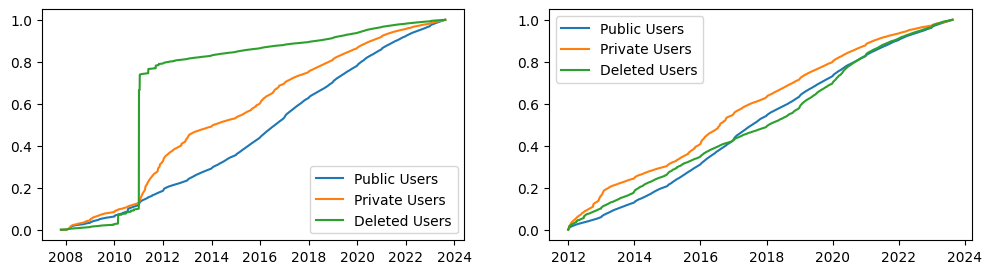

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].plot(joining_dates,joining_date_public_user_CDF,label ='Public Users')
axes[0].plot(joining_dates,joining_date_private_users_CDF,label ='Private Users')
axes[0].plot(joining_dates,joining_date_deleted_users_CDF,label ='Deleted Users')
axes[0].legend()

axes[1].plot(joining_dates_2011,joining_date_2011_public_user_CDF,label ='Public Users')
axes[1].plot(joining_dates_2011,joining_date_2011_private_users_CDF,label ='Private Users')
axes[1].plot(joining_dates_2011,joining_date_2011_deleted_users_CDF,label ='Deleted Users')
axes[1].legend()

# Number of commitment per user CDF (>=1)

In [59]:
commitments_per_user = [v['number_of_commitments'] for k,v in user_index.items() if v['number_of_commitments']>0]

In [60]:
sorted(Counter(commitments_per_user).items(), key=lambda x:x[1],reverse=True)[:10]

[(1, 187333),
 (2, 33338),
 (3, 10952),
 (4, 4656),
 (5, 2421),
 (6, 1463),
 (7, 901),
 (8, 660),
 (9, 437),
 (10, 355)]

In [61]:
unique_commitments_per_user = list(set(commitments_per_user))

In [62]:
unique_commitments_per_user.sort()

In [63]:
len(unique_commitments_per_user)

143

In [64]:
total_users_with_commitments = 0
for k,v in user_index.items():
    if v['number_of_commitments']>0:
        total_users_with_commitments+=1

In [65]:
no_of_commitments_CDF = np.zeros(len(unique_commitments_per_user))
for k,v in tqdm(user_index.items()):
    if v['number_of_commitments']>0:
        count_index = unique_commitments_per_user.index(v['number_of_commitments'])
        no_of_commitments_CDF[count_index:]+=1

  0%|          | 0/655750 [00:00<?, ?it/s]

In [66]:
no_of_commitments_CDF/=total_users_with_commitments

Removing outliars

{'whiskers': [<matplotlib.lines.Line2D at 0x7f71be15da80>,
 'caps': [<matplotlib.lines.Line2D at 0x7f71be15d0c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f71be15ed40>],
 'medians': [<matplotlib.lines.Line2D at 0x7f71be15c1c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f71be15f910>],
 'means': []}

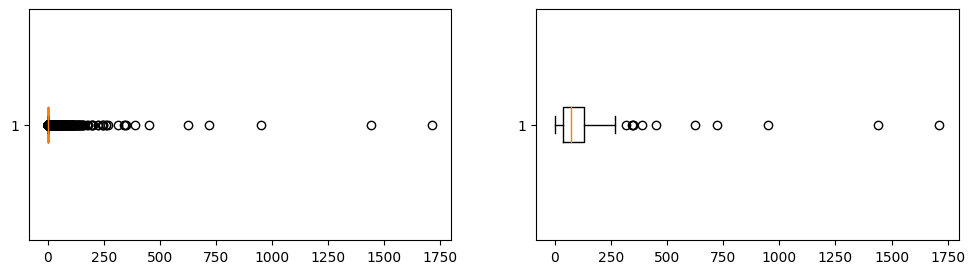

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].boxplot(commitments_per_user, vert=False)
axes[1].boxplot(unique_commitments_per_user, vert=False)

In [68]:
median, IQR, low_lim, up_lim = get_outlier(commitments_per_user)
median, IQR, low_lim, up_lim

(1.0, 0.0, 1.0, 1.0)

In [69]:
median, IQR, low_lim, up_lim = get_outlier(unique_commitments_per_user)
median, IQR, low_lim, up_lim

(72.0, 95.5, 1, 275.25)

In [70]:
unique_commitments_per_user_outlier = [i for i in unique_commitments_per_user if i>=low_lim and i<=up_lim]

In [71]:
unique_commitments_per_user_outlier.sort()

In [72]:
len(unique_commitments_per_user_outlier)

132

In [73]:
no_of_commitments_outlier_CDF = np.zeros(len(unique_commitments_per_user_outlier))
for k,v in tqdm(user_index.items()):
    if v['number_of_commitments']>=low_lim and v['number_of_commitments']<=up_lim:
        count_index = unique_commitments_per_user_outlier.index(v['number_of_commitments'])
        no_of_commitments_outlier_CDF[count_index:]+=1

  0%|          | 0/655750 [00:00<?, ?it/s]

In [74]:
no_of_commitments_outlier_CDF/=total_users_with_commitments

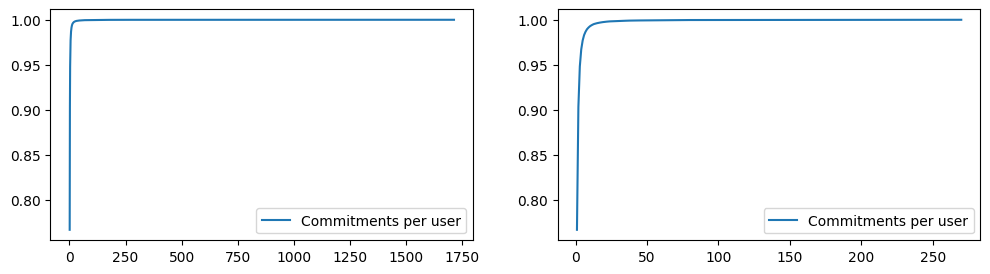

In [75]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].plot(unique_commitments_per_user,no_of_commitments_CDF,label ='Commitments per user')
axes[0].legend()

axes[1].plot(unique_commitments_per_user_outlier,no_of_commitments_outlier_CDF,label ='Commitments per user')
axes[1].legend()

In [76]:
for i in [99,95,90,80,75,50]:
    print(f"{i}%ile users have < {np.percentile(commitments_per_user, i, method = 'midpoint')} commitments")

99%ile users have < 9.0 commitments
95%ile users have < 4.0 commitments
90%ile users have < 2.0 commitments
80%ile users have < 2.0 commitments
75%ile users have < 1.0 commitments
50%ile users have < 1.0 commitments


# Default Display Image

In [77]:
display_image_default = [v['default_image'] for k,v in user_index.items()]

In [78]:
Counter(display_image_default)

Counter({True: 550085, False: 105665})

# No of commitments made Month

In [79]:
month_values = []
for y in range(2007,2024):
    for m in range(1,13):
        month_values.append(datetime(y,m,1)) 

In [80]:
commitment_count_date = np.zeros(len(month_values))
for k,v in tqdm(commitment_index.items()):
    start_m = datetime(v['start_date'].year,v['start_date'].month,1)
    date_index = month_values.index(start_m)
    commitment_count_date[date_index]+=1

  0%|          | 0/397456 [00:00<?, ?it/s]

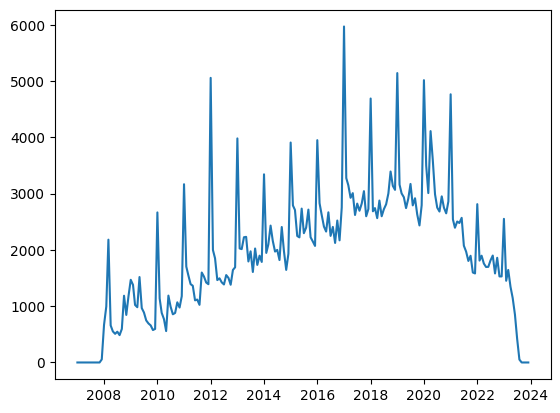

In [81]:
plt.plot(month_values,commitment_count_date)

## Length of commitment

In [82]:
commitment_lengths = [v['length_in_days'] for k,v in commitment_index.items()]

In [83]:
min(commitment_lengths),max(commitment_lengths)

(0, 17774)

In [84]:
sorted(Counter(commitment_lengths).items(), key=lambda x:x[1],reverse=True)

[(84, 47880),
 (56, 38803),
 (28, 35044),
 (112, 18131),
 (140, 18012),
 (7, 16641),
 (364, 15172),
 (42, 14739),
 (70, 14411),
 (35, 13947),
 (14, 10631),
 (2, 9392),
 (21, 9164),
 (105, 6055),
 (49, 4691),
 (168, 4614),
 (63, 4398),
 (91, 4347),
 (210, 3992),
 (98, 3243),
 (77, 3057),
 (6, 3031),
 (175, 2836),
 (3, 2786),
 (182, 2759),
 (126, 2683),
 (280, 2578),
 (5, 2422),
 (4, 2375),
 (350, 2303),
 (154, 2224),
 (31, 2141),
 (8, 2103),
 (30, 2088),
 (119, 1830),
 (1, 1759),
 (29, 1366),
 (245, 1285),
 (196, 1244),
 (147, 1223),
 (693, 1131),
 (9, 1118),
 (336, 1113),
 (224, 1100),
 (32, 1060),
 (365, 1037),
 (133, 1023),
 (10, 1004),
 (252, 924),
 (161, 887),
 (231, 841),
 (11, 834),
 (15, 803),
 (13, 787),
 (189, 783),
 (12, 729),
 (33, 698),
 (22, 684),
 (203, 677),
 (315, 670),
 (27, 663),
 (36, 663),
 (308, 658),
 (20, 623),
 (16, 601),
 (34, 591),
 (43, 587),
 (217, 562),
 (26, 549),
 (25, 543),
 (18, 539),
 (24, 539),
 (357, 525),
 (61, 522),
 (420, 506),
 (294, 498),
 (90, 

{'whiskers': [<matplotlib.lines.Line2D at 0x7f71b4920370>,
 'caps': [<matplotlib.lines.Line2D at 0x7f71b4920790>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f71b49200d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f71b4920cd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f71b4920f70>],
 'means': []}

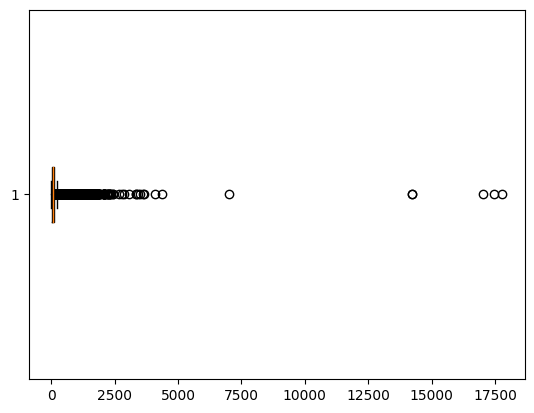

In [85]:
plt.boxplot(commitment_lengths,vert=False)

In [86]:
median, IQR, low_lim, up_lim = get_outlier(commitment_lengths)
median, IQR, low_lim, up_lim

(63.0, 84.0, 0, 238.0)

(array([21979., 23216., 14147., 12638., 42988., 16605., 16887.,  6266.,
        41237.,  5758., 15491.,  4003., 49702.,  5751.,  4108.,  6656.,
        18989.,  2406.,  3108.,  1379., 18330.,  1626.,  2533.,  1118.,
         4872.,  3200.,  3065.,   967.,  1424.,   850.,  4188.,   705.,
         1227.,  1423.]),
 array([  0.,   7.,  14.,  21.,  28.,  35.,  42.,  49.,  56.,  63.,  70.,
         77.,  84.,  91.,  98., 105., 112., 119., 126., 133., 140., 147.,
        154., 161., 168., 175., 182., 189., 196., 203., 210., 217., 224.,
        231., 238.]),
 <BarContainer object of 34 artists>)

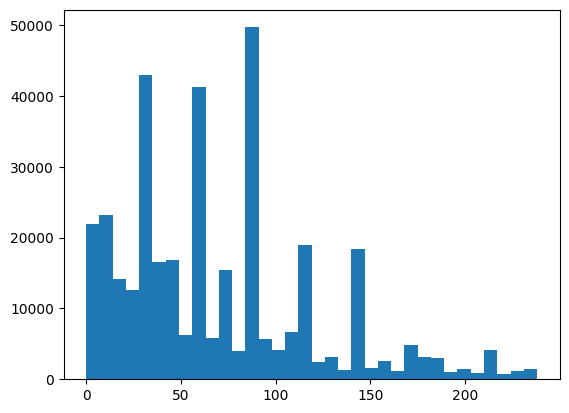

In [87]:
plt.hist(commitment_lengths, bins = [i for i in range(0,239,7)])

In [88]:
commitment_lengths = [int(i/7.0) for i in commitment_lengths]

In [89]:
unique_commitment_lengths = list(set(commitment_lengths))

In [90]:
unique_commitment_lengths.sort()

In [91]:
len(unique_commitment_lengths)

270

In [92]:
commitment_length_CDF = np.zeros(len(unique_commitment_lengths))
for k,v in tqdm(commitment_index.items()):
    count_idx = unique_commitment_lengths.index(int(v['length_in_days']/7.0))
    commitment_length_CDF[count_idx:]+=1

  0%|          | 0/397456 [00:00<?, ?it/s]

In [93]:
commitment_length_CDF/=len(commitment_index)

outliers

In [94]:
commitment_lengths_outlier = [int(i/7.0) for i in commitment_lengths if i>=low_lim and i<=up_lim]

In [95]:
unique_commitment_lengths_outlier = list(set(commitment_lengths_outlier))

In [96]:
min(unique_commitment_lengths_outlier),max(unique_commitment_lengths_outlier)

(0, 33)

In [97]:
len(unique_commitment_lengths_outlier)

34

In [98]:
commitment_length_outlier_CDF = np.zeros(len(unique_commitment_lengths_outlier))
for k,v in tqdm(commitment_index.items()):
    if v['length_in_days']>=low_lim and v['length_in_days']<=up_lim:
        count_idx = unique_commitment_lengths.index(int(v['length_in_days']/7.0))
        commitment_length_outlier_CDF[count_idx:]+=1

  0%|          | 0/397456 [00:00<?, ?it/s]

In [99]:
commitment_length_outlier_CDF/=len(commitment_index)

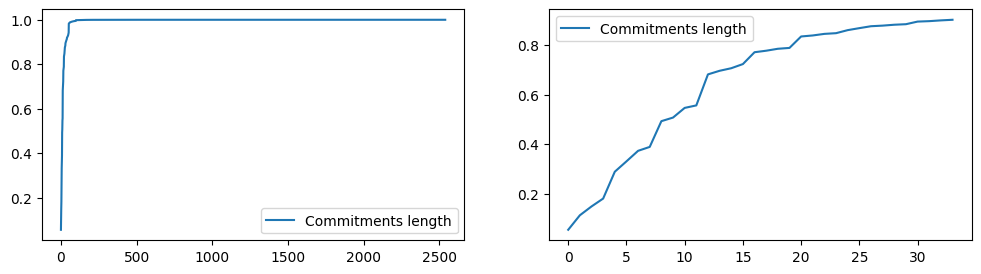

In [100]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].plot(unique_commitment_lengths,commitment_length_CDF,label ='Commitments length')
axes[0].legend()

axes[1].plot(unique_commitment_lengths_outlier,commitment_length_outlier_CDF,label ='Commitments length')
axes[1].legend()

# Date of start

Day 

In [101]:
day_of_start = [v['start_date'].day for k,v in commitment_index.items()]

In [102]:
counts = list(Counter(day_of_start).items())

In [103]:
counts.sort()

In [104]:
day = []
count = []
for i,j in counts:
    day.append(i)
    count.append(j)

In [105]:
(count[0]/np.mean(count))

1.3850539430779758

<BarContainer object of 31 artists>

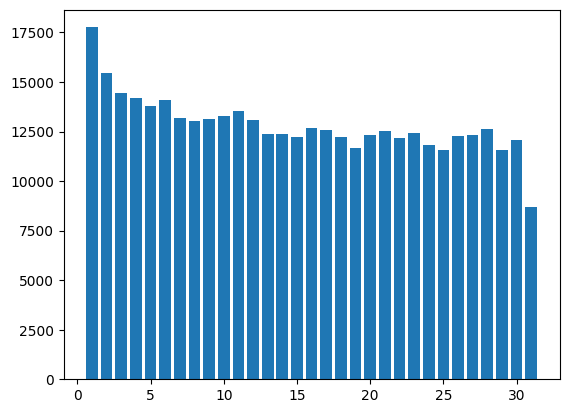

In [106]:
plt.bar(day,count)

In [107]:
count = np.array(count)

In [108]:
count=count[np.newaxis,:]

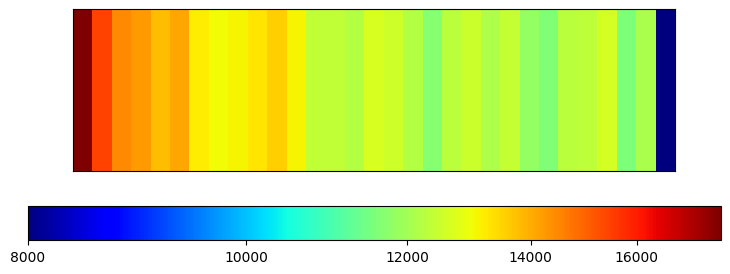

In [109]:
plt.figure(figsize=(24,3))
extent=[0, 186,0,50]
plt.imshow(count, cmap=plt.cm.jet,norm=colors.PowerNorm(gamma=0.6), extent=extent)
plt.gca().set_yticks([])
plt.gca().set_xticks([])
plt.colorbar(orientation='horizontal')
plt.show()

month

In [110]:
month_of_start = [v['start_date'].month for k,v in commitment_index.items()]

In [111]:
counts = list(Counter(month_of_start).items())

In [112]:
counts.sort()

In [113]:
month = []
count = []
for i,j in counts:
    month.append(i)
    count.append(j)

<BarContainer object of 12 artists>

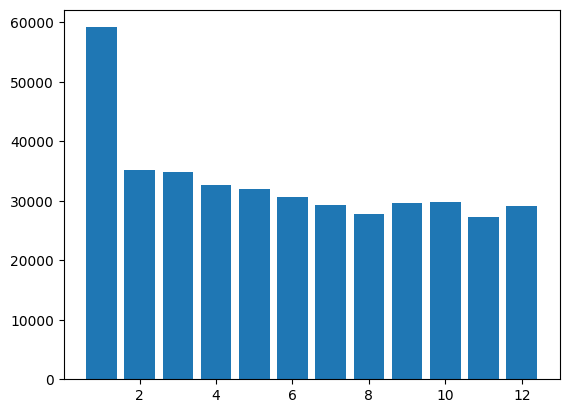

In [114]:
plt.bar(month,count)

365 days

In [115]:
day_of_year = []
count = []
for i in range(1,13):
    for j in range(1,32):
        day_of_year.append(f"{j}_{i}")
        count.append(0)

In [116]:
for k,v in commitment_index.items():
    idx = day_of_year.index(f"{v['start_date'].day}_{v['start_date'].month}")
    count[idx]+=1

In [117]:
max(count)

4294

In [118]:
np.mean(count)

1068.4301075268818

In [119]:
count[:7]

[4294, 3924, 3174, 3140, 2467, 2448, 2081]

In [120]:
for i in range(0,7):
    print((count[i]/np.mean(count)))

4.018980717362425
3.672678233565476
2.9707137393824725
2.9388913489795097
2.308995209532627
2.2912121090133244
1.9477174831931081


<BarContainer object of 372 artists>

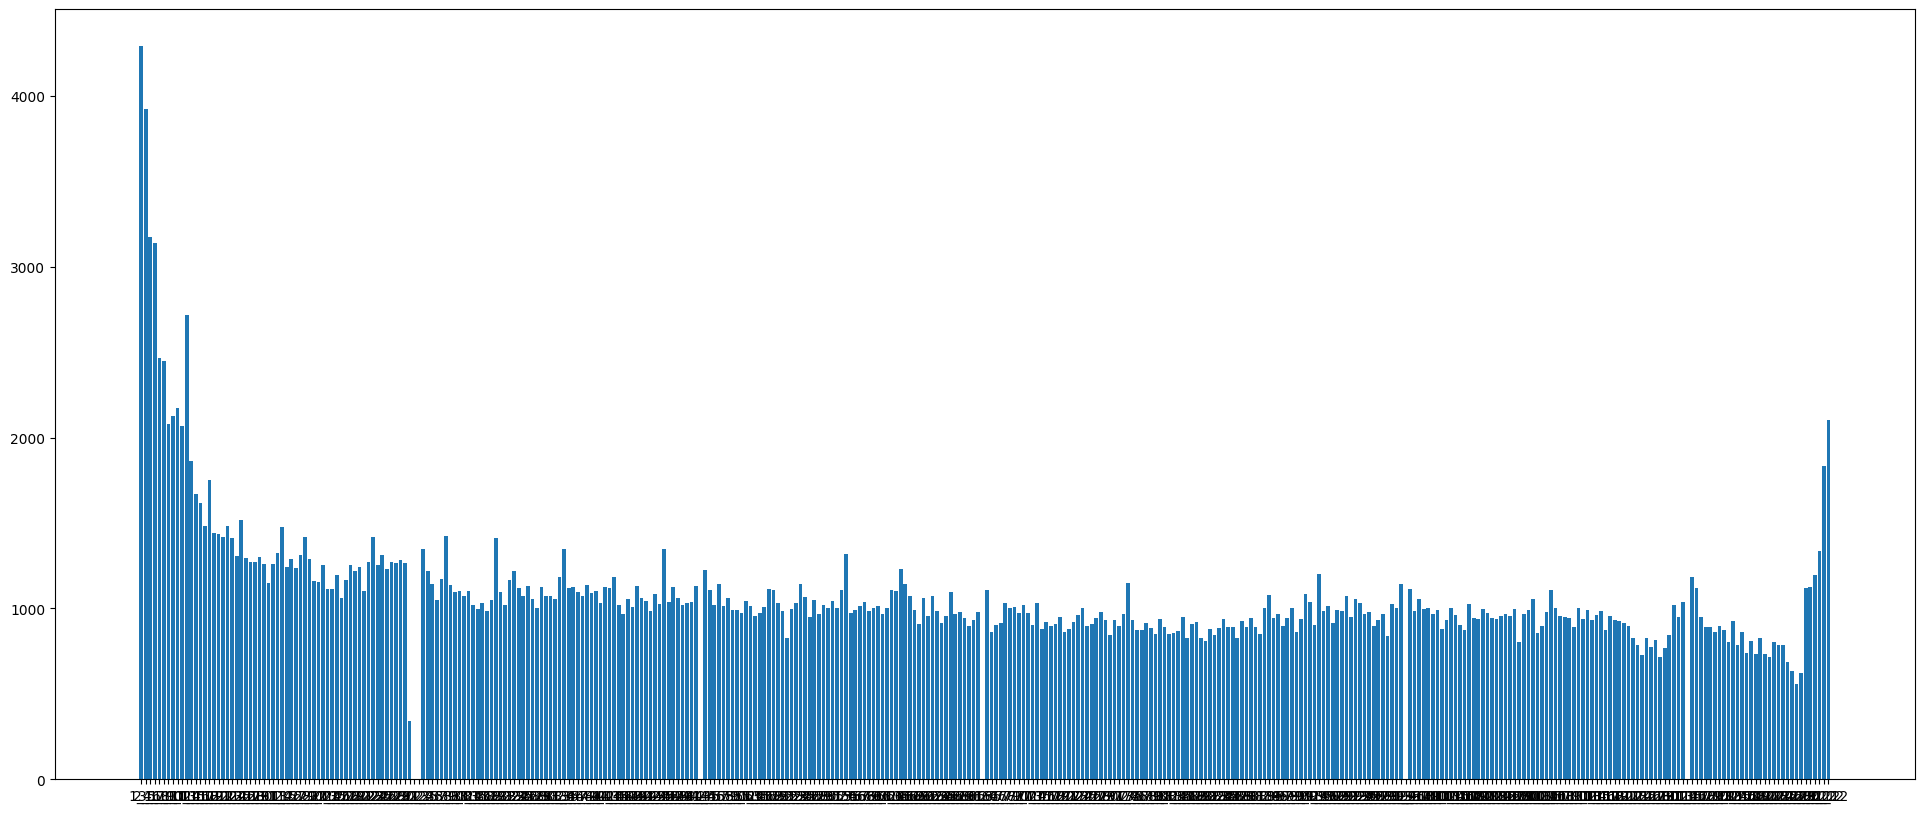

In [121]:
plt.figure(figsize=(24,10))
plt.bar(day_of_year,count)

In [122]:
count = np.array(count)

In [123]:
count=count[np.newaxis,:]

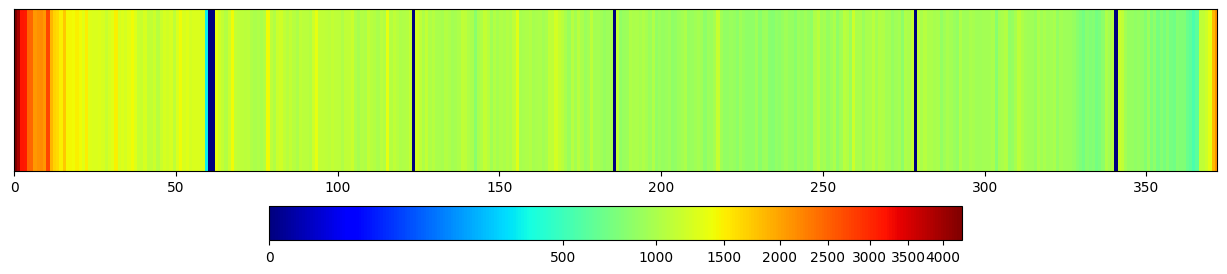

In [124]:
plt.figure(figsize=(24,3))
extent=[0, 372,0,50]
plt.imshow(count, cmap=plt.cm.jet,norm=colors.PowerNorm(gamma=0.4), extent=extent)
plt.gca().set_yticks([])
plt.colorbar(orientation='horizontal')
plt.show()

Weekday

In [125]:
weekday_of_start = [v['start_date'].weekday() for k,v in commitment_index.items()]

In [126]:
counts = list(Counter(weekday_of_start).items())

In [127]:
counts.sort()

In [128]:
day = []
count = []
for i,j in counts:
    day.append(i)
    count.append(j)

In [129]:
np.mean(count)

56779.42857142857

In [130]:
for idx, i in enumerate(count):
    print(idx, (i/np.mean(count)))

0 1.4697752707217906
1 1.0130781772070367
2 0.9204566040014492
3 0.846609436013043
4 0.8011352199991949
5 0.7897930840143311
6 1.1591522080431544


<BarContainer object of 7 artists>

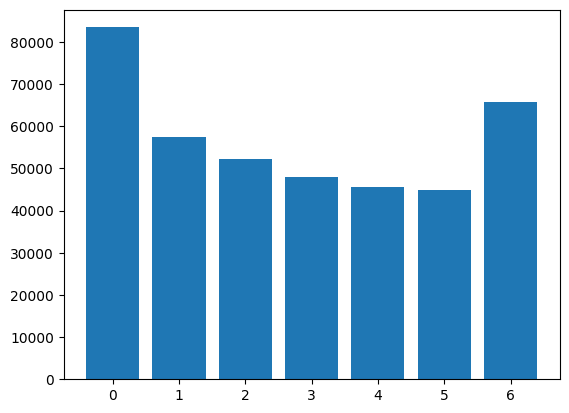

In [131]:
plt.bar(day,count)

In [132]:
count = np.array(count)

In [133]:
count=count[np.newaxis,:]

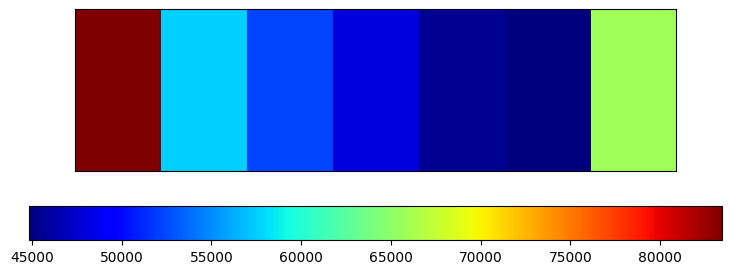

In [134]:
plt.figure(figsize=(24,3))
extent=[0, 186,0,50]
plt.imshow(count, cmap=plt.cm.jet, extent=extent)
plt.gca().set_yticks([])
plt.gca().set_xticks([])
plt.colorbar(orientation='horizontal')
plt.show()

# reporting Interval 

In [135]:
reporting_intervals = [int(v['days_per_reporting']) for k,v in commitment_index.items() if v['no_of_reports']>1]

In [136]:
len(reporting_intervals)

328592

In [137]:
len(set(reporting_intervals))

24

In [138]:
counts = list(Counter(reporting_intervals).items())

In [139]:
counts.sort()

In [140]:
counts

[(0, 6),
 (1, 42263),
 (2, 14),
 (3, 8),
 (4, 15),
 (5, 8),
 (6, 5),
 (7, 286206),
 (8, 12),
 (9, 5),
 (10, 5),
 (11, 10),
 (12, 7),
 (13, 4),
 (14, 5),
 (15, 1),
 (17, 2),
 (18, 3),
 (19, 5),
 (21, 2),
 (22, 1),
 (29, 2),
 (36, 1),
 (45, 2)]

# Stake Type 

In [141]:
stake_type = [v['type_of_stake'] for k,v in commitment_index.items()]

In [142]:
len(stake_type),len(set(stake_type))

(397456, 8)

In [143]:
stake_table = []
for k,v in Counter(stake_type).items():
    stake_table.append((k,v,100*v/len(commitment_index)))

In [144]:
pd.DataFrame(stake_table,columns=['Type','Count','%']).sort_values(by = '%', ascending=False)

,Type,Count,%
0,No stakes,278448,70.057566
3,Anti-charity,60368,15.188599
1,Charity,27053,6.806540
2,Money to a friend,21711,5.462491
4,stickK,5958,1.499034
5,Anti-charity_reverted,1685,0.423946
6,Money to a friend_reverted,1205,0.303178
7,Charity_reverted,1028,0.258645


## Amount of Stake

### Total stake

In [145]:
total_stake = [v['total_stake'] for k,v in commitment_index.items() if (v['type_of_stake']!='No stakes') and ('reverted' not in v['type_of_stake'])]

In [146]:
sorted(Counter(total_stake).items(), key=lambda x:x[1],reverse=True)[:10]

[(100.0, 9786),
 (50.0, 8261),
 (20.0, 6298),
 (40.0, 5765),
 (10.0, 5096),
 (200.0, 5044),
 (5.0, 5029),
 (60.0, 4950),
 (80.0, 4351),
 (120.0, 3711)]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f71bd21e500>,
 'caps': [<matplotlib.lines.Line2D at 0x7f71bd21ea40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f71bd21d8d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f71bd21ef80>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f71bd21f220>],
 'means': []}

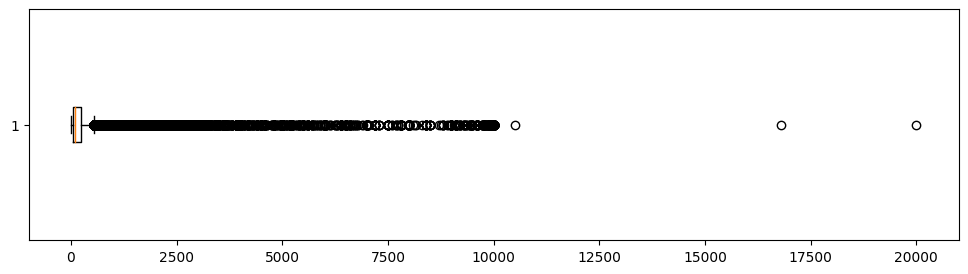

In [147]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
axes.boxplot(total_stake,vert=False)

In [148]:
median, IQR, low_lim, up_lim = get_outlier(total_stake)
median, IQR, low_lim, up_lim

(100.0, 200.0, 0.0, 540.0)

In [149]:
unique_total_stake = list(set(total_stake))

In [150]:
unique_total_stake.sort()

In [151]:
len(unique_total_stake)

1773

In [152]:
total_users_with_stake = 0
for k,v in commitment_index.items():
    if (v['type_of_stake']!='No stakes') and ('reverted' not in v['type_of_stake']):
        total_users_with_stake+=1
total_users_with_stake

115090

In [153]:
total_stake_CDF = np.zeros(len(unique_total_stake))
for k,v in tqdm(commitment_index.items()):
    if (v['type_of_stake']!='No stakes') and ('reverted' not in v['type_of_stake']):
        count_index = unique_total_stake.index(v['total_stake'])
        total_stake_CDF[count_index:]+=1

  0%|          | 0/397456 [00:00<?, ?it/s]

In [154]:
total_stake_CDF/=total_users_with_stake

outlier

In [155]:
total_stake_outlier = [i for i in total_stake if i>=low_lim and i<=up_lim]

In [156]:
min(total_stake_outlier),max(total_stake_outlier)

(0.0, 540.0)

In [157]:
unique_total_stake_outlier = list(set(total_stake_outlier))

In [158]:
unique_total_stake_outlier.sort()

In [159]:
len(unique_total_stake_outlier)

1077

In [160]:
total_stake_outlier_CDF = np.zeros(len(unique_total_stake_outlier))
for k,v in tqdm(commitment_index.items()):
    if (v['type_of_stake']!='No stakes') and ('reverted' not in v['type_of_stake']) and v['total_stake']>=low_lim and v['total_stake']<=up_lim:
        count_index = unique_total_stake_outlier.index(v['total_stake'])
        total_stake_outlier_CDF[count_index:]+=1

  0%|          | 0/397456 [00:00<?, ?it/s]

In [161]:
total_stake_outlier_CDF/=total_users_with_stake

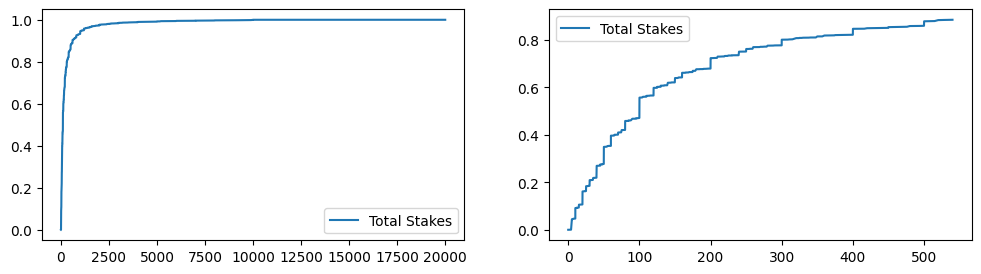

In [162]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].plot(unique_total_stake,total_stake_CDF,label ='Total Stakes')
axes[0].legend()

axes[1].plot(unique_total_stake_outlier,total_stake_outlier_CDF,label ='Total Stakes')
axes[1].legend()

#### Amount VS Type of Stake

In [163]:
unique_total_stake.sort()

In [164]:
len(unique_total_stake)

1773

In [165]:
stickK_users_with_stake = 0
Money_to_a_friend_users_with_stake = 0
Charity_users_with_stake = 0
Anti_charity_users_with_stake = 0
for k,v in commitment_index.items():
    if v['type_of_stake'] == 'stickK':
        stickK_users_with_stake+=1
    elif v['type_of_stake'] == 'Money to a friend':
        Money_to_a_friend_users_with_stake+=1
    elif v['type_of_stake'] == 'Charity':
        Charity_users_with_stake+=1
    elif v['type_of_stake'] == 'Anti-charity':
        Anti_charity_users_with_stake+=1

stickK_users_with_stake,Money_to_a_friend_users_with_stake,Charity_users_with_stake,Anti_charity_users_with_stake

(5958, 21711, 27053, 60368)

In [166]:
stickK_stake_CDF = np.zeros(len(unique_total_stake))
Money_to_a_friend_stake_CDF = np.zeros(len(unique_total_stake))
Charity_stake_CDF = np.zeros(len(unique_total_stake))
Anti_charity_stake_CDF = np.zeros(len(unique_total_stake))
for k,v in tqdm(commitment_index.items()):
    if v['type_of_stake'] == 'stickK':
        count_index = unique_total_stake.index(v['total_stake'])
        stickK_stake_CDF[count_index:]+=1
    elif v['type_of_stake'] == 'Money to a friend':
        count_index = unique_total_stake.index(v['total_stake'])
        Money_to_a_friend_stake_CDF[count_index:]+=1
    elif v['type_of_stake'] == 'Charity':
        count_index = unique_total_stake.index(v['total_stake'])
        Charity_stake_CDF[count_index:]+=1
    elif v['type_of_stake'] == 'Anti-charity':
        count_index = unique_total_stake.index(v['total_stake'])
        Anti_charity_stake_CDF[count_index:]+=1

  0%|          | 0/397456 [00:00<?, ?it/s]

In [167]:
stickK_stake_CDF/=stickK_users_with_stake
Money_to_a_friend_stake_CDF/=Money_to_a_friend_users_with_stake
Charity_stake_CDF/=Charity_users_with_stake
Anti_charity_stake_CDF/=Anti_charity_users_with_stake

In [168]:
stickK_stake_outlier_CDF = np.zeros(len(unique_total_stake_outlier))
Money_to_a_friend_stake_outlier_CDF = np.zeros(len(unique_total_stake_outlier))
Charity_stake_outlier_CDF = np.zeros(len(unique_total_stake_outlier))
Anti_charity_stake_outlier_CDF = np.zeros(len(unique_total_stake_outlier))
for k,v in tqdm(commitment_index.items()):
    if v['total_stake']>=low_lim and v['total_stake']<=up_lim:
        if v['type_of_stake'] == 'stickK':
            count_index = unique_total_stake_outlier.index(v['total_stake'])
            stickK_stake_outlier_CDF[count_index:]+=1
        elif v['type_of_stake'] == 'Money to a friend':
            count_index = unique_total_stake_outlier.index(v['total_stake'])
            Money_to_a_friend_stake_outlier_CDF[count_index:]+=1
        elif v['type_of_stake'] == 'Charity':
            count_index = unique_total_stake_outlier.index(v['total_stake'])
            Charity_stake_outlier_CDF[count_index:]+=1
        elif v['type_of_stake'] == 'Anti-charity':
            count_index = unique_total_stake_outlier.index(v['total_stake'])
            Anti_charity_stake_outlier_CDF[count_index:]+=1

  0%|          | 0/397456 [00:00<?, ?it/s]

In [169]:
stickK_stake_outlier_CDF/=stickK_users_with_stake
Money_to_a_friend_stake_outlier_CDF/=Money_to_a_friend_users_with_stake
Charity_stake_outlier_CDF/=Charity_users_with_stake
Anti_charity_stake_outlier_CDF/=Anti_charity_users_with_stake

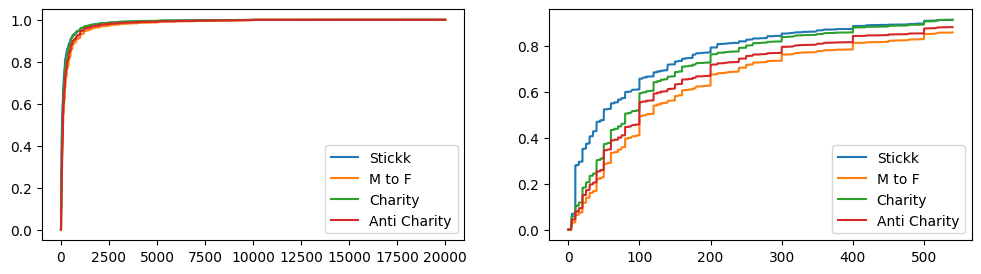

In [170]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].plot(unique_total_stake,stickK_stake_CDF,label ='Stickk')
axes[0].plot(unique_total_stake,Money_to_a_friend_stake_CDF,label ='M to F')
axes[0].plot(unique_total_stake,Charity_stake_CDF,label ='Charity')
axes[0].plot(unique_total_stake,Anti_charity_stake_CDF,label ='Anti Charity')
axes[0].legend()


axes[1].plot(unique_total_stake_outlier,stickK_stake_outlier_CDF,label ='Stickk')
axes[1].plot(unique_total_stake_outlier,Money_to_a_friend_stake_outlier_CDF,label ='M to F')
axes[1].plot(unique_total_stake_outlier,Charity_stake_outlier_CDF,label ='Charity')
axes[1].plot(unique_total_stake_outlier,Anti_charity_stake_outlier_CDF,label ='Anti Charity')
axes[1].legend()

### Stake per period

In [171]:
stake_per_period = [v['stake_per_period'] for k,v in commitment_index.items() if (v['type_of_stake']!='No stakes') and ('reverted' not in v['type_of_stake'])]

In [172]:
sorted(Counter(stake_per_period).items(), key=lambda x:x[1],reverse=True)

[(5.0, 29859),
 (10.0, 19967),
 (50.0, 13535),
 (20.0, 11035),
 (100.0, 10421),
 (25.0, 5918),
 (15.0, 3087),
 (30.0, 2771),
 (200.0, 2180),
 (40.0, 1816),
 (500.0, 1643),
 (150.0, 936),
 (300.0, 936),
 (250.0, 834),
 (1000.0, 829),
 (75.0, 714),
 (7.0, 631),
 (35.0, 568),
 (60.0, 410),
 (8.0, 321),
 (6.0, 305),
 (400.0, 270),
 (12.0, 257),
 (80.0, 251),
 (70.0, 227),
 (12.5, 194),
 (125.0, 147),
 (1.0, 146),
 (45.0, 144),
 (2000.0, 125),
 (14.0, 90),
 (11.0, 85),
 (120.0, 80),
 (800.0, 80),
 (7.5, 78),
 (13.0, 78),
 (49.0, 74),
 (90.0, 72),
 (700.0, 71),
 (9.0, 68),
 (600.0, 65),
 (6.25, 63),
 (33.0, 61),
 (1500.0, 61),
 (350.0, 61),
 (2.0, 54),
 (6.66, 53),
 (5000.0, 52),
 (18.0, 52),
 (17.0, 51),
 (55.0, 47),
 (21.0, 46),
 (3000.0, 44),
 (16.0, 44),
 (65.0, 43),
 (175.0, 40),
 (900.0, 37),
 (3.0, 36),
 (140.0, 35),
 (750.0, 34),
 (9999.0, 34),
 (7000.0, 34),
 (24.0, 33),
 (62.5, 31),
 (31.25, 30),
 (22.0, 28),
 (450.0, 28),
 (19.0, 27),
 (27.0, 26),
 (5.01, 25),
 (180.0, 24),
 (16.6

{'whiskers': [<matplotlib.lines.Line2D at 0x7f71b5b6c610>,
 'caps': [<matplotlib.lines.Line2D at 0x7f71b5b6cb50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f71b5bbcac0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f71b5b6d090>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f71b5b6d330>],
 'means': []}

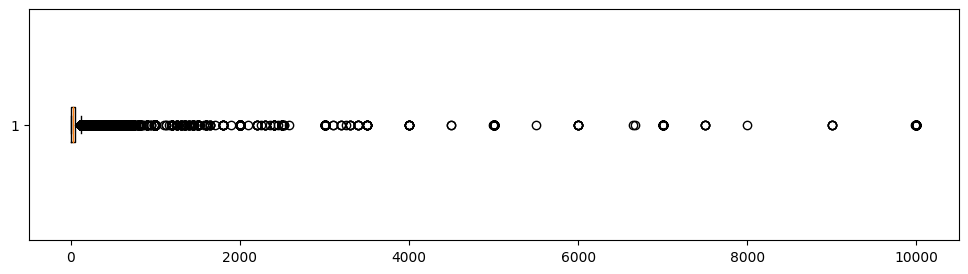

In [173]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
axes.boxplot(stake_per_period,vert=False)

In [174]:
median, IQR, low_lim, up_lim = get_outlier(stake_per_period)
median, IQR, low_lim, up_lim

(20.0, 45.0, 0.0, 117.5)

In [175]:
unique_stake_per_period = list(set(stake_per_period))

In [176]:
unique_stake_per_period.sort()

In [177]:
len(unique_stake_per_period)

938

In [178]:
stake_per_period_CDF = np.zeros(len(unique_stake_per_period))
for k,v in tqdm(commitment_index.items()):
    if (v['type_of_stake']!='No stakes') and ('reverted' not in v['type_of_stake']):
        count_index = unique_stake_per_period.index(v['stake_per_period'])
        stake_per_period_CDF[count_index:]+=1

  0%|          | 0/397456 [00:00<?, ?it/s]

In [179]:
stake_per_period_CDF/=total_users_with_stake

Outlier

In [180]:
stake_per_period_outlier = [i for i in stake_per_period if i>=low_lim and i<=up_lim]

In [181]:
min(stake_per_period_outlier),max(stake_per_period_outlier)

(0.0, 117.0)

In [182]:
unique_stake_per_period_outlier = list(set(stake_per_period_outlier))

In [183]:
unique_stake_per_period_outlier.sort()

In [184]:
len(unique_stake_per_period_outlier)

628

In [185]:
stake_per_period_outlier_CDF = np.zeros(len(unique_stake_per_period_outlier))
for k,v in tqdm(commitment_index.items()):
    if (v['type_of_stake']!='No stakes') and ('reverted' not in v['type_of_stake']) and v['stake_per_period']>=low_lim and v['stake_per_period']<=up_lim:
        count_index = unique_stake_per_period_outlier.index(v['stake_per_period'])
        stake_per_period_outlier_CDF[count_index:]+=1

  0%|          | 0/397456 [00:00<?, ?it/s]

In [186]:
stake_per_period_outlier_CDF/=total_users_with_stake

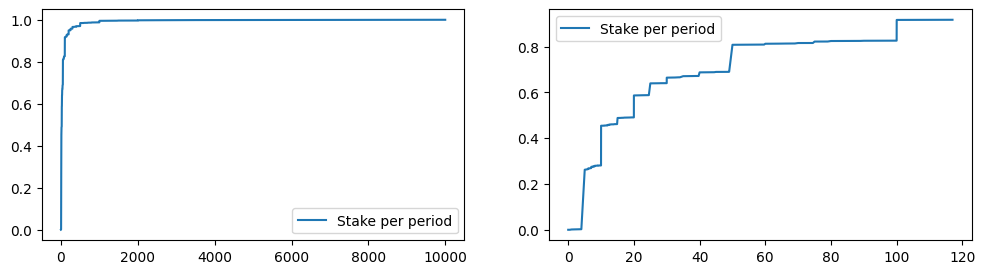

In [187]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].plot(unique_stake_per_period,stake_per_period_CDF,label ='Stake per period')
axes[0].legend()

axes[1].plot(unique_stake_per_period_outlier,stake_per_period_outlier_CDF,label ='Stake per period')
axes[1].legend()

#### Amount per period VS type of Stake

In [188]:
unique_stake_per_period.sort()

In [189]:
len(unique_stake_per_period)

938

In [190]:
stickK_stake_CDF = np.zeros(len(unique_stake_per_period))
Money_to_a_friend_stake_CDF = np.zeros(len(unique_stake_per_period))
Charity_stake_CDF = np.zeros(len(unique_stake_per_period))
Anti_charity_stake_CDF = np.zeros(len(unique_stake_per_period))
for k,v in tqdm(commitment_index.items()):
    if v['type_of_stake'] == 'stickK':
        count_index = unique_stake_per_period.index(v['stake_per_period'])
        stickK_stake_CDF[count_index:]+=1
    elif v['type_of_stake'] == 'Money to a friend':
        count_index = unique_stake_per_period.index(v['stake_per_period'])
        Money_to_a_friend_stake_CDF[count_index:]+=1
    elif v['type_of_stake'] == 'Charity':
        count_index = unique_stake_per_period.index(v['stake_per_period'])
        Charity_stake_CDF[count_index:]+=1
    elif v['type_of_stake'] == 'Anti-charity':
        count_index = unique_stake_per_period.index(v['stake_per_period'])
        Anti_charity_stake_CDF[count_index:]+=1

  0%|          | 0/397456 [00:00<?, ?it/s]

In [191]:
stickK_stake_CDF/=stickK_users_with_stake
Money_to_a_friend_stake_CDF/=Money_to_a_friend_users_with_stake
Charity_stake_CDF/=Charity_users_with_stake
Anti_charity_stake_CDF/=Anti_charity_users_with_stake

In [192]:
stickK_stake_outlier_CDF = np.zeros(len(unique_stake_per_period_outlier))
Money_to_a_friend_stake_outlier_CDF = np.zeros(len(unique_stake_per_period_outlier))
Charity_stake_outlier_CDF = np.zeros(len(unique_stake_per_period_outlier))
Anti_charity_stake_outlier_CDF = np.zeros(len(unique_stake_per_period_outlier))
for k,v in tqdm(commitment_index.items()):
    if v['stake_per_period']>=low_lim and v['stake_per_period']<=up_lim:
        if v['type_of_stake'] == 'stickK':
            count_index = unique_stake_per_period_outlier.index(v['stake_per_period'])
            stickK_stake_outlier_CDF[count_index:]+=1
        elif v['type_of_stake'] == 'Money to a friend':
            count_index = unique_stake_per_period_outlier.index(v['stake_per_period'])
            Money_to_a_friend_stake_outlier_CDF[count_index:]+=1
        elif v['type_of_stake'] == 'Charity':
            count_index = unique_stake_per_period_outlier.index(v['stake_per_period'])
            Charity_stake_outlier_CDF[count_index:]+=1
        elif v['type_of_stake'] == 'Anti-charity':
            count_index = unique_stake_per_period_outlier.index(v['stake_per_period'])
            Anti_charity_stake_outlier_CDF[count_index:]+=1

  0%|          | 0/397456 [00:00<?, ?it/s]

In [193]:
stickK_stake_outlier_CDF/=stickK_users_with_stake
Money_to_a_friend_stake_outlier_CDF/=Money_to_a_friend_users_with_stake
Charity_stake_outlier_CDF/=Charity_users_with_stake
Anti_charity_stake_outlier_CDF/=Anti_charity_users_with_stake

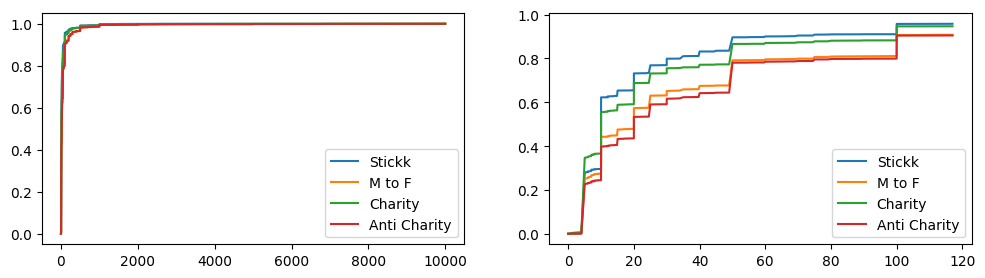

In [194]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].plot(unique_stake_per_period,stickK_stake_CDF,label ='Stickk')
axes[0].plot(unique_stake_per_period,Money_to_a_friend_stake_CDF,label ='M to F')
axes[0].plot(unique_stake_per_period,Charity_stake_CDF,label ='Charity')
axes[0].plot(unique_stake_per_period,Anti_charity_stake_CDF,label ='Anti Charity')
axes[0].legend()


axes[1].plot(unique_stake_per_period_outlier,stickK_stake_outlier_CDF,label ='Stickk')
axes[1].plot(unique_stake_per_period_outlier,Money_to_a_friend_stake_outlier_CDF,label ='M to F')
axes[1].plot(unique_stake_per_period_outlier,Charity_stake_outlier_CDF,label ='Charity')
axes[1].plot(unique_stake_per_period_outlier,Anti_charity_stake_outlier_CDF,label ='Anti Charity')
axes[1].legend()

## Refree 

In [195]:
refree = [v['self_refree'] for k,v in commitment_index.items()]

In [196]:
for k,v in Counter(refree).items():
    print(k,v,v*100/len(commitment_index))

True 322010 81.01777303651222
False 75446 18.982226963487783


### Support

In [197]:
supporters = [v['no_of_supporters'] for k,v in commitment_index.items()]

In [198]:
min(supporters),max(supporters)

(0, 32)

In [199]:
Counter(supporters)

Counter({0: 363023,
         1: 26897,
         2: 4853,
         3: 1462,
         4: 561,
         5: 252,
         6: 139,
         7: 58,
         8: 57,
         9: 41,
         11: 21,
         10: 18,
         13: 11,
         30: 11,
         12: 10,
         16: 6,
         29: 5,
         31: 5,
         14: 4,
         26: 4,
         15: 3,
         18: 3,
         25: 2,
         28: 2,
         27: 2,
         19: 1,
         17: 1,
         22: 1,
         20: 1,
         23: 1,
         32: 1})

In [201]:
Counter(supporters)[0]*100/len(commitment_index)

91.33665110100237

## Reporting Success, Not Reported, not successfull

In [202]:
sucessful = []
not_sucessful = []
not_reported = []
for k,v in tqdm(commitment_index.items()):
    sucessful.append(v['sucessful']*100/v['no_of_reports'])
    not_sucessful.append(v['not_sucessful']*100/v['no_of_reports'])
    not_reported.append(v['not_reported']*100/v['no_of_reports'])

  0%|          | 0/397456 [00:00<?, ?it/s]

(array([213977.,  12541.,   9608.,   6161.,   4420.,   8189.,   5400.,
          2967.,   4161.,   1272.,   8564.,   2685.,   4262.,   4580.,
          2458.,   8094.,   7047.,   6193.,   7574.,  77303.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

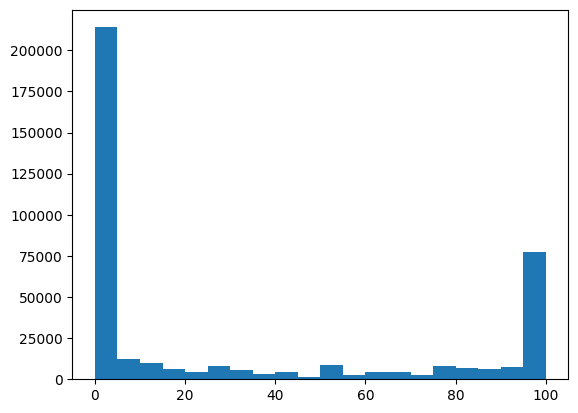

In [203]:
plt.hist(sucessful,bins = [i for i in range(0,101,5)])

(array([3.27109e+05, 1.55900e+04, 1.18830e+04, 6.55500e+03, 4.49900e+03,
        8.57700e+03, 4.32000e+03, 1.74700e+03, 2.36200e+03, 4.55000e+02,
        4.10700e+03, 7.02000e+02, 1.02500e+03, 9.04000e+02, 3.00000e+02,
        1.03100e+03, 4.91000e+02, 2.53000e+02, 1.88000e+02, 5.35800e+03]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

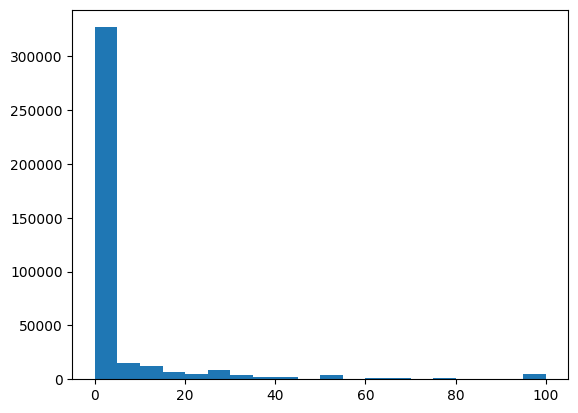

In [204]:
plt.hist(not_sucessful,bins = [i for i in range(0,101,5)])

(array([100844.,   7564.,   7350.,   4606.,   3347.,   7146.,   4345.,
          2412.,   3446.,   1207.,   7486.,   2696.,   3971.,   4420.,
          2595.,   7871.,   7794.,   8297.,  13803., 196256.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

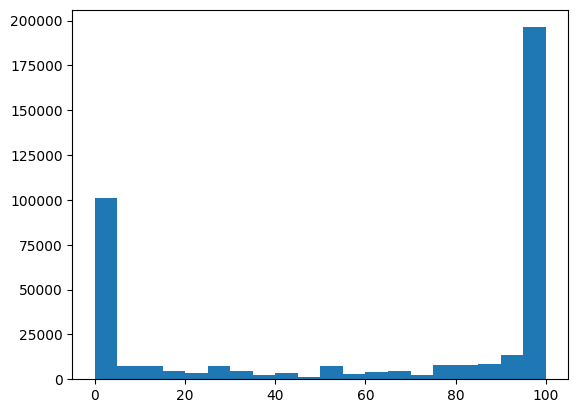

In [205]:
plt.hist(not_reported,bins = [i for i in range(0,101,5)])

## Length vs Success

In [206]:
duration = []
success_percentage = []

for k,v in commitment_index.items():
    duration.append(v['length_in_days'])
    success_percentage.append(v['sucessful']*100/v['no_of_reports'])

In [207]:
median, IQR, low_lim, up_lim = get_outlier(duration)
median, IQR, low_lim, up_lim

(63.0, 84.0, 0, 238.0)

In [208]:
# median, IQR, low_lim, up_lim = get_outlier(list(set(duration)))
# median, IQR, low_lim, up_lim

In [209]:
duration_outlier = []
success_percentage_outlier = []

for k,v in commitment_index.items():
    if v['length_in_days']>=low_lim and v['length_in_days']<=up_lim:
        duration_outlier.append(v['length_in_days'])
        success_percentage_outlier.append(v['sucessful']*100/v['no_of_reports'])

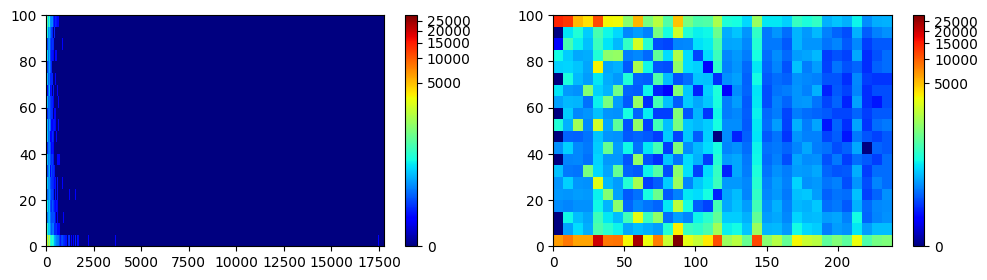

In [210]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.hist2d(duration, success_percentage, bins=(int(max(duration)/7), 20),norm=colors.PowerNorm(gamma=0.2), cmap=plt.cm.jet)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.hist2d(duration_outlier, success_percentage_outlier, bins=(int(max(duration_outlier)/7), 20),norm=colors.PowerNorm(gamma=0.2), cmap=plt.cm.jet)
plt.colorbar()

## Length vs Not reported

In [211]:
duration = []
not_reported_percentage = []

for k,v in commitment_index.items():
    duration.append(v['length_in_days'])
    not_reported_percentage.append(v['not_reported']*100/v['no_of_reports'])

In [212]:
duration_outlier = []
not_reported_percentage_outlier = []

for k,v in commitment_index.items():
    if v['length_in_days']>=low_lim and v['length_in_days']<=up_lim:
        duration_outlier.append(v['length_in_days'])
        not_reported_percentage_outlier.append(v['not_reported']*100/v['no_of_reports'])

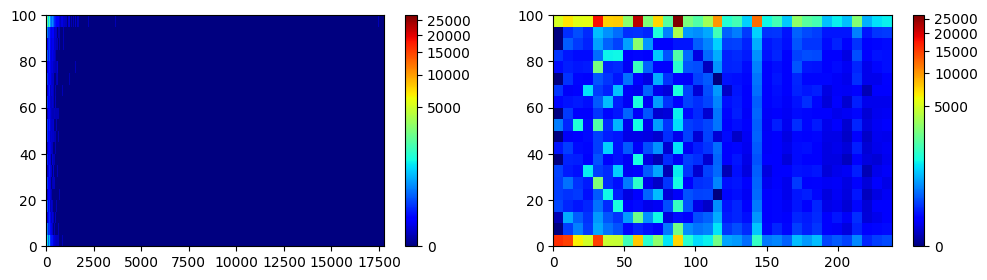

In [213]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.hist2d(duration, not_reported_percentage, bins=(int(max(duration)/7), 20),norm=colors.PowerNorm(gamma=0.3), cmap=plt.cm.jet)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.hist2d(duration_outlier, not_reported_percentage_outlier, bins=(int(max(duration_outlier)/7), 20),norm=colors.PowerNorm(gamma=0.3), cmap=plt.cm.jet)
plt.colorbar()

## Stake_per_period vs Success

In [214]:
stake = []
success_percentage = []

for k,v in commitment_index.items():
    stake.append(v['stake_per_period'])
    success_percentage.append(v['sucessful']*100/v['no_of_reports'])

In [215]:
median, IQR, low_lim, up_lim = get_outlier(list(set(stake)))
median, IQR, low_lim, up_lim

(33.875, 193.96, 0.0, 493.94)

In [216]:
# median, IQR, low_lim, up_lim = get_outlier(stake)
# median, IQR, low_lim, up_lim

In [217]:
stake_outlier = []
success_percentage_outlier = []

for k,v in commitment_index.items():
    if v['stake_per_period']>=low_lim and v['stake_per_period']<=up_lim:
        stake_outlier.append(v['stake_per_period'])
        success_percentage_outlier.append(v['sucessful']*100/v['no_of_reports'])

In [218]:
foo = Counter(success_percentage).values()

In [219]:
min(foo),max(foo)

(1, 203149)

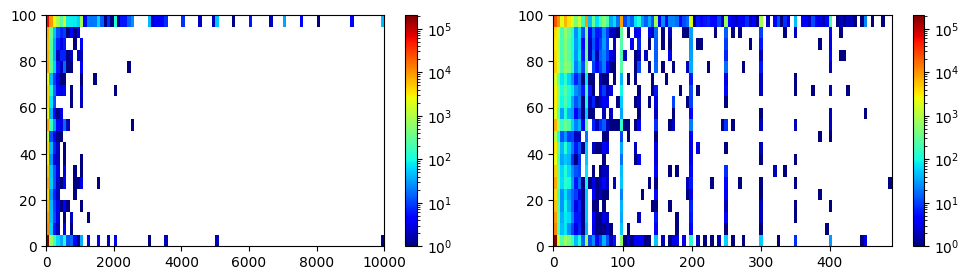

In [220]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.hist2d(stake, success_percentage, bins=(int(max(stake)/100), 20),norm=colors.LogNorm(vmin=min(foo), vmax=max(foo)), cmap=plt.cm.jet)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.hist2d(stake_outlier, success_percentage_outlier, bins=(int(max(stake_outlier)/5), 20),norm=colors.LogNorm(vmin=min(foo), vmax=max(foo)), cmap=plt.cm.jet)
plt.colorbar()

## Total Stake vs success

In [221]:
stake = []
success_percentage = []

for k,v in commitment_index.items():
    stake.append(v['total_stake'])
    success_percentage.append(v['sucessful']*100/v['no_of_reports'])

In [222]:
median, IQR, low_lim, up_lim = get_outlier(list(set(stake)))
median, IQR, low_lim, up_lim

(297.0, 1202.46, 0.0, 3071.19)

In [223]:
# median, IQR, low_lim, up_lim = get_outlier(stake)
# median, IQR, low_lim, up_lim

In [224]:
stake_outlier = []
success_percentage_outlier = []

for k,v in commitment_index.items():
    if v['total_stake']>=low_lim and v['total_stake']<=up_lim:
        stake_outlier.append(v['total_stake'])
        success_percentage_outlier.append(v['sucessful']*100/v['no_of_reports'])

In [225]:
foo = Counter(success_percentage).values()

In [226]:
min(foo),max(foo)

(1, 203149)

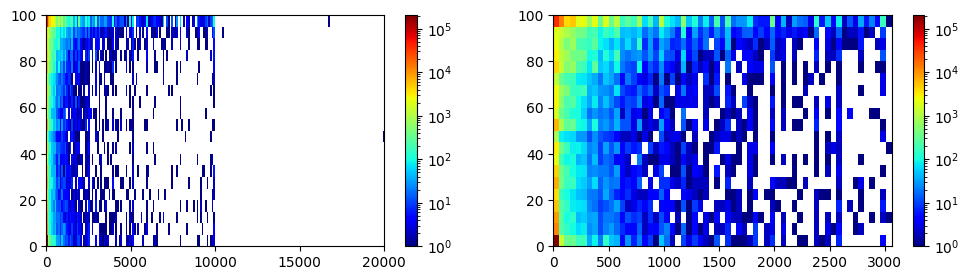

In [227]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.hist2d(stake, success_percentage, bins=(int(max(stake)/100), 20),norm=colors.LogNorm(vmin=min(foo), vmax=max(foo)), cmap=plt.cm.jet)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.hist2d(stake_outlier, success_percentage_outlier, bins=(int(max(stake_outlier)/50), 20),norm=colors.LogNorm(vmin=min(foo), vmax=max(foo)), cmap=plt.cm.jet)
plt.colorbar()

# Type of Stake vs success

In [228]:
stake_data = defaultdict(lambda: {"sucessful":[],"not_sucessful":[],"not_reported":[]})
for k,v in commitment_index.items():
    stake_data[v['type_of_stake']]['sucessful'].append(v['sucessful']*100/v['no_of_reports'])
    stake_data[v['type_of_stake']]['not_sucessful'].append(v['not_sucessful']*100/v['no_of_reports'])
    stake_data[v['type_of_stake']]['not_reported'].append(v['not_reported']*100/v['no_of_reports'])

In [229]:
raw_data = []
for k,v in stake_data.items():
    temp = [k]
    for i in ['sucessful','not_sucessful','not_reported']:
        temp.append(f'{np.mean(v[i]):.2f} ± {np.std(v[i])}')
    raw_data.append(temp)

In [230]:
pd.DataFrame(raw_data,columns=['Type',"Success", "Not Success" , "Not reported"]).sort_values(by = 'Success', ascending=False)

,Type,Success,Not Success,Not reported
3,Anti-charity,85.75 ± 27.321252717620194,5.20 ± 16.18340222658682,9.06 ± 22.506652817375553
4,stickK,83.14 ± 30.498246535600515,6.26 ± 19.178181751313698,10.60 ± 25.168978612437016
2,Money to a friend,75.05 ± 33.46830684652241,9.34 ± 20.484219613174506,15.61 ± 28.20760125589772
1,Charity,73.47 ± 34.4991646325517,8.63 ± 19.900731081407912,17.90 ± 30.520538390986452
5,Anti-charity_reverted,43.86 ± 29.145043596157787,7.35 ± 12.528023487652675,48.79 ± 30.847451525014844
7,Charity_reverted,39.06 ± 29.008779955242478,7.60 ± 13.018041630940925,53.34 ± 31.297252743953045
6,Money to a friend_reverted,39.01 ± 28.914715487241832,10.03 ± 15.658029696255344,50.97 ± 31.653049558290064
0,No stakes,11.44 ± 25.41477203956148,4.66 ± 14.884657700737435,83.90 ± 30.812674919850995


# Title Word cloud

In [231]:
titles = [v['title'] for k,v in commitment_index.items()]

In [232]:
titles = [i.lower() for i in titles]

In [233]:
titles = [i for i in titles if i!=""]

In [234]:
titles = [i.translate(str.maketrans('', '', string.punctuation)) for i in titles]

In [235]:
tokens = []
for i in titles:
    for k in i.split(" "):
        tokens.append(k)

In [236]:
tokens = [i for i in tokens if i!=""]

In [237]:
sorted(Counter(tokens).items(), key=lambda x:x[1],reverse=True)

[('weight', 98411),
 ('lose', 95713),
 ('exercise', 72615),
 ('regularly', 70372),
 ('a', 20768),
 ('to', 13494),
 ('my', 13451),
 ('for', 12247),
 ('quit', 11554),
 ('and', 11418),
 ('day', 11348),
 ('no', 10910),
 ('smoking', 10137),
 ('the', 9199),
 ('week', 8899),
 ('of', 8621),
 ('in', 8010),
 ('at', 7353),
 ('daily', 7122),
 ('on', 6834),
 ('study', 6810),
 ('up', 6530),
 ('get', 6231),
 ('every', 6096),
 ('finish', 5587),
 ('read', 5553),
 ('work', 5155),
 ('by', 5026),
 ('per', 4722),
 ('write', 4594),
 ('more', 4420),
 ('5', 4263),
 ('1', 4204),
 ('eat', 4024),
 ('i', 4013),
 ('learn', 3917),
 ('2', 3828),
 ('days', 3806),
 ('complete', 3793),
 ('3', 3786),
 ('hours', 3637),
 ('wake', 3598),
 ('race', 3545),
 ('do', 3525),
 ('stop', 3400),
 ('everyday', 3235),
 ('30', 3137),
 ('meditate', 3036),
 ('10', 3002),
 ('maintain', 2975),
 ('time', 2910),
 ('journal', 2833),
 ('be', 2791),
 ('or', 2718),
 ('drink', 2676),
 ('book', 2656),
 ('eating', 2616),
 ('with', 2517),
 ('minutes

In [238]:
wc_text = " ".join(tokens)

In [239]:
len(wc_text)

7323808

In [240]:
wordcloud = WordCloud(stopwords=set(STOPWORDS) ,background_color="white").generate(wc_text)

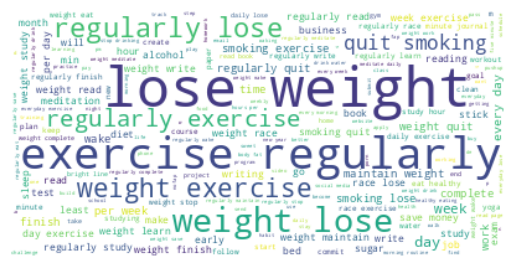

In [241]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Not reported and never came back

In [242]:
future_commitments = []
no_report_percentage = []

for k,v in tqdm(commitment_index.items()):
    no_report_percentage.append(v['not_reported']*100/v['no_of_reports'])
    count = 0
    cut_off_date = v['end_date']
    for c_id in user_index[str(v['user_id'])]['commitments']:
        if commitment_index[str(c_id)] != k:
            if commitment_index[str(c_id)]['start_date']>=cut_off_date:
                count+=1
    future_commitments.append(count)

  0%|          | 0/397456 [00:00<?, ?it/s]

In [243]:
len(future_commitments),len(no_report_percentage)

(397456, 397456)

In [244]:
min(future_commitments),max(future_commitments)

(0, 1712)

In [245]:
no_report_percentage, future_commitments = zip(*[(i,j) for i,j in zip(no_report_percentage,future_commitments) if j>0])

In [246]:
len(future_commitments),len(no_report_percentage)

(85815, 85815)

In [247]:
min(future_commitments),max(future_commitments)

(1, 1712)

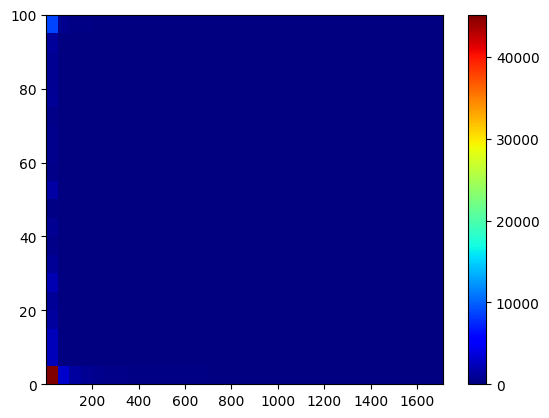

In [248]:
plt.hist2d(future_commitments, no_report_percentage, bins=(int(max(future_commitments)/50), 20), cmap=plt.cm.jet)
plt.colorbar()

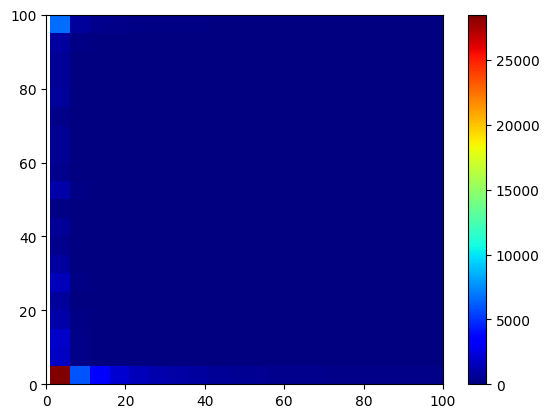

In [249]:
plt.hist2d(future_commitments, no_report_percentage, bins=(int(max(future_commitments)/5), 20), cmap=plt.cm.jet)
plt.xlim((0,100))
plt.colorbar()

# money lost

In [250]:
money_no_report = []
money_no_sucessful = []

for k,v in tqdm(commitment_index.items()):
    money_no_sucessful.append(v['stake_per_period']*v['not_sucessful'])
    money_no_report.append(v['stake_per_period']*v['not_reported'])

  0%|          | 0/397456 [00:00<?, ?it/s]

In [251]:
sum(money_no_report), sum(money_no_sucessful)

(4257531.359999997, 1554770.05)